In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from tabulate import tabulate
import joblib
import numpy as np
import xgboost as xgb

# Load datasets
flight_info = pd.read_csv('flight_information.csv', index_col=0)
ground_info = pd.read_csv('ground_information.csv', index_col=0)

# Merge datasets on common columns
merged_data = pd.merge(flight_info, ground_info, on=['fn_number', 'ac_registration'], how='inner')

# Separate categorical and numerical columns
categorical_columns = merged_data.select_dtypes(include=['object']).columns
numerical_columns = merged_data.select_dtypes(include=[np.number]).columns

# Impute missing values in numerical columns using kNN
knn_imputer = KNNImputer(n_neighbors=5)
merged_data[numerical_columns] = knn_imputer.fit_transform(merged_data[numerical_columns])

# Convert datetime columns to datetime objects
merged_data['arr_sched_datetime'] = pd.to_datetime(merged_data['arr_sched_date'] + ' ' + merged_data['arr_sched_time'])
merged_data['dep_sched_date_origin'] = merged_data['dep_sched_date']

# Calculate total_departure_delay
merged_data['total_departure_delay'] = (
    merged_data['trans_time'] +
    merged_data['catering_duration'] +
    merged_data['cleaning_duration'] +
    merged_data['pax_boarding_duration']
)

# Calculate true_arrival_time
merged_data['true_arrival_time'] = merged_data['arr_sched_datetime'] + pd.to_timedelta(merged_data['total_departure_delay'], unit='m')

# Convert true_arrival_time to numeric values (seconds since epoch)
merged_data['true_arrival_time_numeric'] = (
    merged_data['true_arrival_time'].dt.hour * 3600 +
    merged_data['true_arrival_time'].dt.minute * 60 +
    merged_data['true_arrival_time'].dt.second
)

# Drop rows with NaT values in total_departure_delay
merged_data.dropna(subset=['total_departure_delay'], inplace=True)

# Impute missing values in categorical columns with mode
for column in categorical_columns:
    mode_value = merged_data[column].mode()[0]
    merged_data[column].fillna(mode_value, inplace=True)

# Drop unnecessary columns
merged_data.drop(columns=['arr_sched_datetime', 'true_arrival_time', 'total_departure_delay'], inplace=True)

# Update categorical columns after dropping datetime columns
categorical_columns_excluding_date = [col for col in categorical_columns if col not in ['dep_sched_date_origin']]

# Apply LabelEncoding to categorical columns
label_encoders = {col: LabelEncoder() for col in categorical_columns_excluding_date}
for col, encoder in label_encoders.items():
    merged_data[col] = encoder.fit_transform(merged_data[col])

# Save the label encoders
joblib.dump(label_encoders, 'label_encoders.pkl')

# Split the data into training and testing sets based on dep_sched_date_origin
train_data = merged_data[merged_data['dep_sched_date_origin'] < '2019-06-24']
test_data = merged_data[merged_data['dep_sched_date_origin'] >= '2019-06-24']

# Separate features and target variable
X_train = train_data.drop(columns=['true_arrival_time_numeric', 'dep_sched_date_origin'])
y_train = train_data['true_arrival_time_numeric']
X_test = test_data.drop(columns=['true_arrival_time_numeric', 'dep_sched_date_origin'])
y_test = test_data['true_arrival_time_numeric']

# Initialize the MinMaxScaler for feature normalization to range (-1, 1)
feature_scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

# Initialize the StandardScaler for z-score normalization of the target variable
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Define models
models = {
      'GradientBoosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
      'MLPRegressor': MLPRegressor(hidden_layer_sizes=(50, 25), activation='relu', solver='adam', learning_rate='adaptive',
                        learning_rate_init=0.01, max_iter=1000, alpha=0.001, random_state=42),
      'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
      'XGBRegressor':xgb.XGBRegressor( n_estimators=100,learning_rate=0.1,max_depth=3, random_state=42, objective='reg:squarederror')
}

# Function to display metrics for both scaled and original units
def display_metrics(model_name, r2, rmse_scaled, mae_scaled, dataset_name, std_y):
    rmse_original_seconds = rmse_scaled * std_y
    rmse_original_minutes = rmse_original_seconds / 60
    mae_original_seconds = mae_scaled * std_y
    mae_original_minutes = mae_original_seconds / 60
    return [model_name, dataset_name, r2, rmse_scaled, f"{rmse_original_minutes:.2f}", mae_scaled, f"{mae_original_minutes:.2f}"]

# Collect results in a table
results_table = []

# Loop over models and calculate metrics
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train_scaled)
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Training metrics
    r2_train = r2_score(y_train_scaled, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train_scaled, y_train_pred))
    mae_train = mean_absolute_error(y_train_scaled, y_train_pred)
    results_table.append(display_metrics(model_name, r2_train, rmse_train, mae_train, "Training Set", target_scaler.scale_[0]))

    # Test metrics
    r2_test = r2_score(y_test_scaled, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test_scaled, y_test_pred))
    mae_test = mean_absolute_error(y_test_scaled, y_test_pred)
    results_table.append(display_metrics(model_name, r2_test, rmse_test, mae_test, "Test Set", target_scaler.scale_[0]))

# Define headers
headers = ["Model", "Dataset", "R²", "RMSE (scaled)", "RMSE (minutes)", "MAE (scaled)", "MAE (minutes)"]

# Display results in a table
print(tabulate(results_table, headers=headers, tablefmt='pretty'))

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_58412\3395100110.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data[column].fillna(mode_value, inplace=True)


+------------------+--------------+--------------------+----------------------+----------------+----------------------+---------------+
|      Model       |   Dataset    |         R²         |    RMSE (scaled)     | RMSE (minutes) |     MAE (scaled)     | MAE (minutes) |
+------------------+--------------+--------------------+----------------------+----------------+----------------------+---------------+
| GradientBoosting | Training Set | 0.9996017259918144 | 0.019956803556320298 |      5.41      |  0.0148927321470117  |     4.04      |
| GradientBoosting |   Test Set   | 0.9994522984591627 | 0.023979311056775632 |      6.50      | 0.01676899613210398  |     4.55      |
|   MLPRegressor   | Training Set | 0.9988432657782108 | 0.03401079566533556  |      9.22      | 0.025161613247585587 |     6.82      |
|   MLPRegressor   |   Test Set   | 0.9949155831147464 | 0.07306094683287674  |     19.80      | 0.031029838393612983 |     8.41      |
|   RandomForest   | Training Set | 0.9996212516


Selected Features that contribute up to 99.99% of the total importance:
['arr_sched_time', 'trans_time', 'pax_boarding_duration', 'catering_duration']


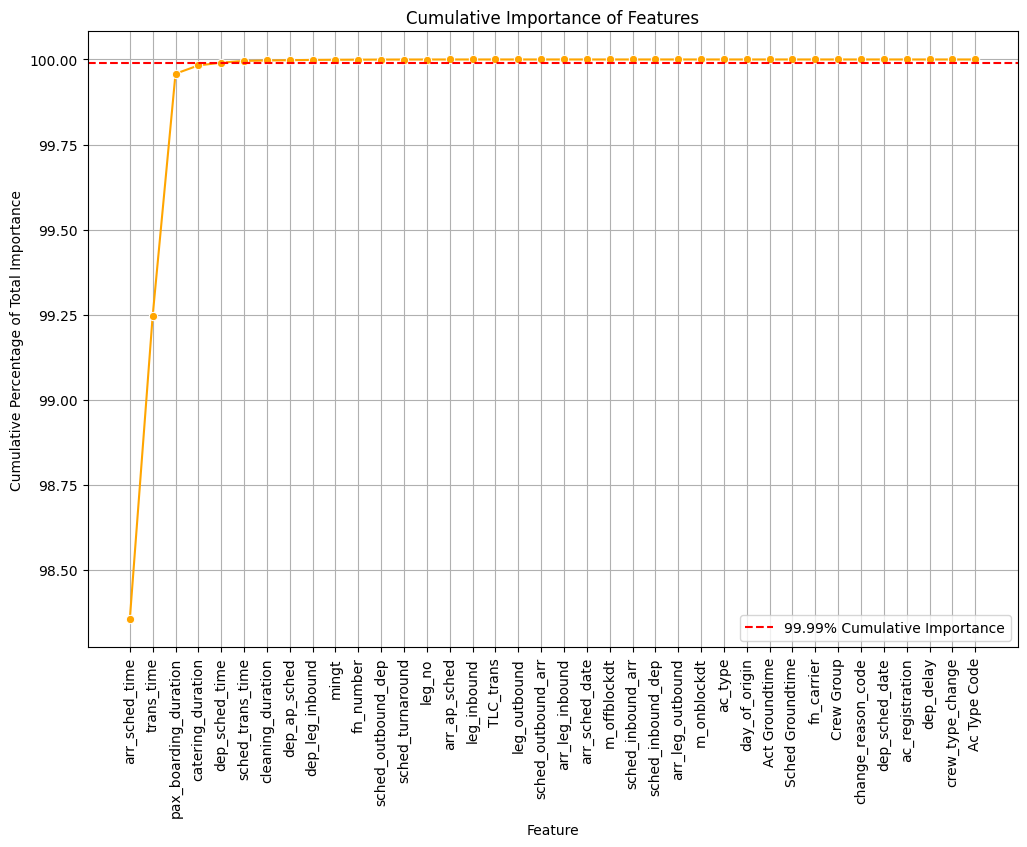

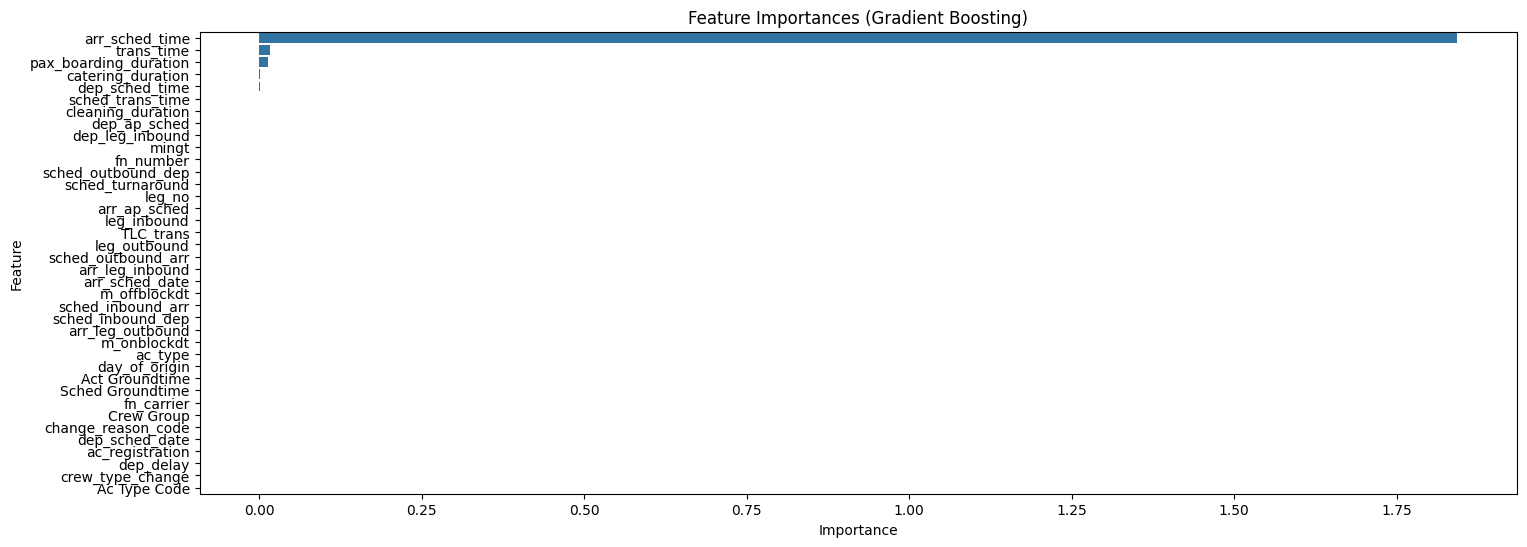

In [4]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train_scaled, y_train_scaled)

# Compute permutation feature importance for Gradient Boosting model
result = permutation_importance(model, X_test_scaled, y_test_scaled, n_repeats=10, random_state=42, n_jobs=-1)

# Get the importance scores and their standard deviation
importance_scores = result.importances_mean
importance_std = result.importances_std

# Create a DataFrame to display feature importance
features = X_train.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importance_scores,
    'Standard Deviation': importance_std
}).sort_values(by='Importance', ascending=False)

# Calculate cumulative importance
importance_df['Cumulative Importance'] = importance_df['Importance'].cumsum()
total_importance = importance_df['Importance'].sum()
importance_df['Cumulative Percentage'] = (importance_df['Cumulative Importance'] / total_importance) * 100

# Select features that contribute up to 95% of the total importance
threshold = 99.99
selected_features = importance_df[importance_df['Cumulative Percentage'] <= threshold]['Feature'].tolist()

print(f"\nSelected Features that contribute up to {threshold}% of the total importance:")
print(selected_features)

# Plot Cumulative Importance of Features
plt.figure(figsize=(12, 8))
sns.lineplot(x=importance_df['Feature'], y=importance_df['Cumulative Percentage'], marker='o', color='orange')
plt.axhline(y=threshold, color='r', linestyle='--', label=f'{threshold}% Cumulative Importance')
plt.xlabel('Feature')
plt.ylabel('Cumulative Percentage of Total Importance')
plt.title('Cumulative Importance of Features')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)

# Save and show the plot
plt.savefig('Cumulative_Importance_GB.png', format='png', dpi=100)
plt.show()

# Optionally, plot feature importances (if available)
plt.figure(figsize=(17, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances (Gradient Boosting)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.savefig('Feature_importances_GB.png', format='png', dpi=100)
plt.show()

In [5]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Filter training and test sets to include only selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Apply the MinMaxScaler transformation to selected features
X_train_scaled_selected = feature_scaler.fit_transform(X_train_selected)
X_test_scaled_selected = feature_scaler.transform(X_test_selected)

# Initialize the XGBRegressor model
model_xgb = xgb.XGBRegressor(
    n_estimators=100,         # Number of trees
    learning_rate=0.1,        # Step size shrinkage
    max_depth=6,              # Maximum depth of a tree
    random_state=42,          # For reproducibility
    objective='reg:squarederror'  # Use squared error as loss function
)


# Train the RandomForest model on the selected and scaled features
model_xgb.fit(X_train_scaled_selected, y_train_scaled)

# Make predictions on both training and test sets
y_train_pred_rf = model_xgb.predict(X_train_scaled_selected)
y_test_pred_rf = model_xgb.predict(X_test_scaled_selected)

# Assuming the custom display_metrics function exists, and target_scaler is defined
# Get the standard deviation of the target variable for scaling back to the original units
std_y = target_scaler.scale_[0]  # Standard deviation for the target variable

# Function to display metrics for both scaled and original units
def display_metrics(r2, rmse_scaled, mae_scaled, mse_scaled, dataset_name, std_y):
    # Convert RMSE and MAE from scaled to original units (in seconds and minutes)
    rmse_original_seconds = rmse_scaled * std_y
    rmse_original_minutes = rmse_original_seconds / 60

    mae_original_seconds = mae_scaled * std_y
    mae_original_minutes = mae_original_seconds / 60

    print(f"\n{dataset_name} Metrics:")
    print(f"R-squared (R²): {r2:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse_scaled:.4f} ({rmse_original_minutes:.2f} minutes)")
    print(f"Mean Absolute Error (MAE): {mae_scaled:.4f} ({mae_original_minutes:.2f} minutes)")

# Calculate and display metrics for the training set (Random Forest)
r2_train_rf = r2_score(y_train_scaled, y_train_pred_rf)
rmse_train_rf = np.sqrt(mean_squared_error(y_train_scaled, y_train_pred_rf))
mae_train_rf = mean_absolute_error(y_train_scaled, y_train_pred_rf)
mse_train_rf = mean_squared_error(y_train_scaled, y_train_pred_rf)

display_metrics(r2_train_rf, rmse_train_rf, mae_train_rf, mse_train_rf, "Training Set (Gradient Boost)", std_y)

# Calculate and display metrics for the test set (Random Forest)
r2_test_rf = r2_score(y_test_scaled, y_test_pred_rf)
rmse_test_rf = np.sqrt(mean_squared_error(y_test_scaled, y_test_pred_rf))
mae_test_rf = mean_absolute_error(y_test_scaled, y_test_pred_rf)
mse_test_rf = mean_squared_error(y_test_scaled, y_test_pred_rf)

display_metrics(r2_test_rf, rmse_test_rf, mae_test_rf, mse_test_rf, "Test Set (Gradient Boost)", std_y)


Training Set (Gradient Boost) Metrics:
R-squared (R²): 0.9999
Root Mean Squared Error (RMSE): 0.0092 (2.50 minutes)
Mean Absolute Error (MAE): 0.0067 (1.83 minutes)

Test Set (Gradient Boost) Metrics:
R-squared (R²): 0.9998
Root Mean Squared Error (RMSE): 0.0161 (4.36 minutes)
Mean Absolute Error (MAE): 0.0098 (2.64 minutes)


In [7]:
from tabulate import tabulate
import joblib
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

# Load the saved label encoders for fn_number, dep_sched_date, and dep_sched_time
label_encoders = joblib.load('label_encoders.pkl')
encoder_fn_number = label_encoders['fn_number']
encoder_dep_sched_date = label_encoders['dep_sched_date']
encoder_dep_sched_time = label_encoders['dep_sched_time']

# Get the standard deviation from the scaler (assuming it was saved)
std_y = target_scaler.scale_[0]  # Standard deviation for the target variable

# Assuming X_test already contains 'leg_no'
legs = X_test['leg_no'].unique()  # Get unique flight legs
X_test_indices = list(X_test.index)

rmse_per_leg = []
mae_per_leg = []
results_all = []  # To store the results for all flights (single or multiple legs)
results_multiple_legs = []  # To store the results for flights with at least two legs

# Prepare a list to store all flight details, including the keys for sorting
flight_details = []

# Iterate over leg_no to collect all the relevant information before sorting
for leg in legs:
    # Filter data for each leg based on leg_no
    leg_data = X_test[X_test['leg_no'] == leg]  # Data for this leg
    
    # Fetch the original fn_number and dep_sched_date from the inverse transformed columns
    fn_number_original = encoder_fn_number.inverse_transform([leg_data['fn_number'].iloc[0]])[0]  # Get the first element of fn_number
    dep_sched_date_original = encoder_dep_sched_date.inverse_transform([leg_data['dep_sched_date'].iloc[0]])[0]  # Same for date
    dep_sched_time_original = encoder_dep_sched_time.inverse_transform([leg_data['dep_sched_time'].iloc[0]])[0]  # Same for time

    # Append flight details along with fn_number and dep_sched_date as keys for sorting
    flight_details.append((fn_number_original, dep_sched_date_original, dep_sched_time_original, leg, leg_data))

# Convert to DataFrame to easily count occurrences
flight_df = pd.DataFrame(flight_details, columns=['fn_number', 'dep_sched_date', 'dep_sched_time', 'leg', 'leg_data'])

# Count the number of leg_no per fn_number and dep_sched_date
leg_counts = flight_df.groupby(['fn_number', 'dep_sched_date']).size().reset_index(name='leg_count')

# Filter to include all flights (single and multiple legs)
filtered_all = leg_counts[leg_counts['leg_count'] >= 1]

# Filter to include only those fn_number and dep_sched_date with at least two leg_no
filtered_multiple_legs = leg_counts[leg_counts['leg_count'] >= 2]

# Process all flights (single and multiple legs)
for index, row in filtered_all.iterrows():
    fn_number = row['fn_number']
    dep_sched_date = row['dep_sched_date']
    
    # Get flight details for the filtered fn_number and dep_sched_date
    flight_subset = flight_df[(flight_df['fn_number'] == fn_number) & (flight_df['dep_sched_date'] == dep_sched_date)]
    
    for _, flight_row in flight_subset.iterrows():
        leg = flight_row['leg']
        leg_data = flight_row['leg_data']
        dep_sched_time = flight_row['dep_sched_time']

        # Select only the selected features (11 features) for the model
        try:
            X_test_leg = leg_data[selected_features]  # Filter for the selected features
        except KeyError:
            print(f"Error: Not all selected features found in X_test for leg {leg}")
            continue

        # Get the row positions based on the current leg
        leg_positions = [X_test_indices.index(i) for i in leg_data.index]  # Find matching row positions in the NumPy array
        
        # Filter X_test_scaled using the row positions
        X_test_leg_scaled = X_test_scaled[leg_positions]  # Use the row positions to select from the scaled NumPy array
        
        # Ensure that only the selected features are used in X_test_scaled
        X_test_leg_scaled = X_test_leg_scaled[:, [list(X_test.columns).index(f) for f in selected_features]]

        # Get the corresponding y_test_scaled values for this leg using the same positions
        y_test_leg_scaled = y_test_scaled[leg_positions]  # Target values for the current leg
        
        # Predict using the selected features for the current leg
        y_pred_leg_scaled = model_xgb.predict(X_test_leg_scaled)

        # Reverse the scaling by multiplying the scaled values by the standard deviation (std_y)
        y_test_leg_original = y_test_leg_scaled * std_y
        y_pred_leg_original = y_pred_leg_scaled * std_y
        
        # Calculate RMSE and MAE in the original scale (not scaled)
        rmse_leg = np.sqrt(mean_squared_error(y_test_leg_original, y_pred_leg_original))
        mae_leg = mean_absolute_error(y_test_leg_original, y_pred_leg_original)
        
        # Convert RMSE and MAE to minutes
        rmse_leg_minutes = rmse_leg / 60
        mae_leg_minutes = mae_leg / 60
        
        # Append the calculated RMSE, MAE in minutes, and fn_number to lists, along with the dep_sched_date and dep_sched_time
        rmse_per_leg.append(rmse_leg_minutes)
        mae_per_leg.append(mae_leg_minutes)
        
        # Store the results for all flights (single and multiple legs)
        results_all.append([fn_number, leg, f"{rmse_leg_minutes:.2f} min", f"{mae_leg_minutes:.2f} min", dep_sched_date, dep_sched_time])

# Process only flights with multiple legs
for index, row in filtered_multiple_legs.iterrows():
    fn_number = row['fn_number']
    dep_sched_date = row['dep_sched_date']
    
    # Get flight details for the filtered fn_number and dep_sched_date
    flight_subset = flight_df[(flight_df['fn_number'] == fn_number) & (flight_df['dep_sched_date'] == dep_sched_date)]
    
    for _, flight_row in flight_subset.iterrows():
        leg = flight_row['leg']
        leg_data = flight_row['leg_data']
        dep_sched_time = flight_row['dep_sched_time']

        # Select only the selected features (11 features) for the model
        try:
            X_test_leg = leg_data[selected_features]  # Filter for the selected features
        except KeyError:
            print(f"Error: Not all selected features found in X_test for leg {leg}")
            continue

        # Get the row positions based on the current leg
        leg_positions = [X_test_indices.index(i) for i in leg_data.index]  # Find matching row positions in the NumPy array
        
        # Filter X_test_scaled using the row positions
        X_test_leg_scaled = X_test_scaled[leg_positions]  # Use the row positions to select from the scaled NumPy array
        
        # Ensure that only the selected features are used in X_test_scaled
        X_test_leg_scaled = X_test_leg_scaled[:, [list(X_test.columns).index(f) for f in selected_features]]

        # Get the corresponding y_test_scaled values for this leg using the same positions
        y_test_leg_scaled = y_test_scaled[leg_positions]  # Target values for the current leg
        
        # Predict using the selected features for the current leg
        y_pred_leg_scaled = model_xgb.predict(X_test_leg_scaled)

        # Reverse the scaling by multiplying the scaled values by the standard deviation (std_y)
        y_test_leg_original = y_test_leg_scaled * std_y
        y_pred_leg_original = y_pred_leg_scaled * std_y
        
        # Calculate RMSE and MAE in the original scale (not scaled)
        rmse_leg = np.sqrt(mean_squared_error(y_test_leg_original, y_pred_leg_original))
        mae_leg = mean_absolute_error(y_test_leg_original, y_pred_leg_original)
        
        # Convert RMSE and MAE to minutes
        rmse_leg_minutes = rmse_leg / 60
        mae_leg_minutes = mae_leg / 60
        
        # Append the calculated RMSE, MAE in minutes, and fn_number to lists, along with the dep_sched_date and dep_sched_time
        rmse_per_leg.append(rmse_leg_minutes)
        mae_per_leg.append(mae_leg_minutes)
        
        # Store the results for flights with multiple legs
        results_multiple_legs.append([fn_number, leg, f"{rmse_leg_minutes:.2f} min", f"{mae_leg_minutes:.2f} min", dep_sched_date, dep_sched_time])

# Define the table headers
headers = ['Original fn_number', 'leg_no', 'Average RMSE (minutes)', 'Average MAE (minutes)', 'dep_sched_date', 'dep_sched_time']


# Display the RMSE and MAE per leg for flights with multiple legs
print("Flights with Multiple Legs:")
print(tabulate(results_multiple_legs, headers=headers, tablefmt='pretty'))

# Display the RMSE and MAE per leg for all flights (single and multiple legs)
print("All Flights (Single and Multiple Legs):")
print(tabulate(results_all, headers=headers, tablefmt='pretty'))

# Save all flights (single and multiple legs) results to a text file
table_str_all = tabulate(results_all, headers=headers, tablefmt='pretty')
with open('results_table_all_flights.txt', 'w') as file:
    file.write(table_str_all)

print("Results for all flights saved to 'results_table_all_flights.txt'")

# Save the multiple legs results to a text file
table_str_multiple_legs = tabulate(results_multiple_legs, headers=headers, tablefmt='pretty')
with open('results_table_multiple_legs.txt', 'w') as file:
    file.write(table_str_multiple_legs)

print("Results for multiple legs saved to 'results_table_multiple_legs.txt'")

Flights with Multiple Legs:
+--------------------+-------------+------------------------+-----------------------+----------------+----------------+
| Original fn_number |   leg_no    | Average RMSE (minutes) | Average MAE (minutes) | dep_sched_date | dep_sched_time |
+--------------------+-------------+------------------------+-----------------------+----------------+----------------+
|      EC11860       | 272088112.0 |        1.49 min        |       1.23 min        |   2019-06-30   |     06:50      |
|      EC11860       | 272088113.0 |        4.08 min        |       3.68 min        |   2019-06-30   |     08:30      |
|       EC3117       | 272006261.0 |        7.63 min        |       7.24 min        |   2019-06-27   |     07:50      |
|       EC3117       | 272360102.0 |        3.24 min        |       3.24 min        |   2019-06-27   |     11:30      |
+--------------------+-------------+------------------------+-----------------------+----------------+----------------+
All Flights 

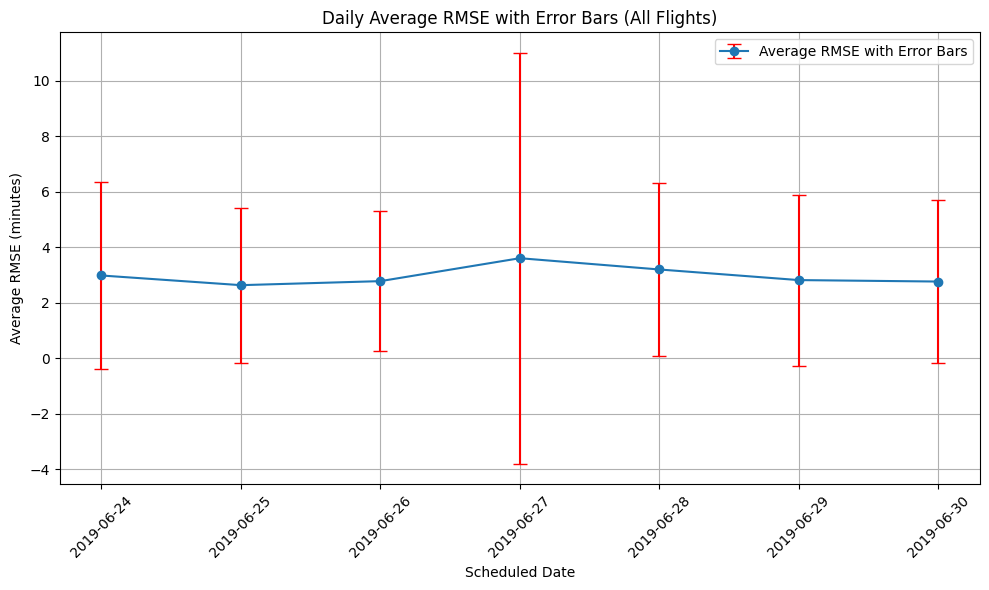

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the rmse_per_leg and dep_sched_date for all flights (from all_flights_results) into a DataFrame
rmse_all_df = pd.DataFrame({
    'dep_sched_date': [result[4] for result in results_all],  # Extract dep_sched_date from all_flights_results
    'rmse_per_leg': [float(result[2].split()[0]) for result in results_all]  # Extract and convert RMSE (minutes) to float
})

# Group by dep_sched_date to calculate the mean RMSE
daily_rmse_avg_all = rmse_all_df.groupby('dep_sched_date').rmse_per_leg.mean()

# Calculate the standard deviation, filling NaNs with 0 (for single-leg flights where std can't be computed)
daily_rmse_std_all = rmse_all_df.groupby('dep_sched_date').rmse_per_leg.std().fillna(0)

# Prepare x-axis values (dates) and y-axis (average RMSE)
dates_all = daily_rmse_avg_all.index
avg_rmse_all = daily_rmse_avg_all.values
std_rmse_all = daily_rmse_std_all.values

# Plot the error bars for all flights (single and multiple legs), with a line linking the points
plt.figure(figsize=(10, 6))
plt.errorbar(dates_all, avg_rmse_all, yerr=std_rmse_all, fmt='o', ecolor='red', capsize=5, label='Average RMSE with Error Bars', linestyle='-')  # Added linestyle='-' to connect points

# Customize the plot
plt.xticks(rotation=45)
plt.xlabel('Scheduled Date')
plt.ylabel('Average RMSE (minutes)')
plt.title('Daily Average RMSE with Error Bars (All Flights)')
plt.grid(True)
plt.tight_layout()
plt.legend()

# Save the plot
plt.savefig('daily_average_rmse_all_flights.png', format='png', dpi=100)

# Show plot
plt.show()
